## SQL INJECTION


In [161]:
import sklearn.feature_extraction
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# importando librerias de matplot 
import seaborn

In [162]:
# leyendo los datos desde los archivos 
import os
import csv
dataframe=pd.read_csv(os.path.join('resultados','consulta_sqlinjection.csv'),encoding='utf-8',sep='|',header=0)   
dataframe.head(15)

consulta_sql      tipo
0                                         ' or 1=1 --      malo
1                                        1' or '1'='1      malo
2                                       a' or 1=1; --      malo
3                                        'any 'x'='x'      malo
4                                            1 or 1=1      malo
5                exec sp_addlogin 'name' , 'password'      malo
6      '; exec master..xp_cmdshell 'ping 10.10.1.2'--      malo
7   '; exec master..xp_cmdshell 'ping aaa.bbb.ccc....      malo
8                                                   A  legitimo
9                                     Buscando a memo  legitimo
10                                   ANALYZE lockdemo  legitimo
11                            select * from employees  legitimo

In [163]:
# describe cuanto malos hay y cuantos legitimos y total
print(dataframe['tipo'].value_counts())
print("Total: %s" % sum(dataframe['tipo'].value_counts()))

malo        8
legitimo    4
Name: tipo, dtype: int64
Total: 12


In [164]:
# Se usa el modulo sqlparse para determinar las instrucciones de SQL, como select,union, etc. ademas de 
# veridicar los tipos ver en
# https://github.com/andialbrecht/sqlparse
import sqlparse
def parse_it(raw_sql):
    parsed = sqlparse.parse(str(raw_sql))
    x=[]
    for parse in parsed:
        for token in parse.tokens:
            if token._get_repr_name() != 'Whitespace':
                x.append(token._get_repr_name())
    return x
dataframe['parseando_sql'] = dataframe['consulta_sql'].map(lambda x: parse_it(x))


In [165]:
dataframe.head(10)


consulta_sql      tipo  \
0                                        ' or 1=1 --      malo   
1                                       1' or '1'='1      malo   
2                                      a' or 1=1; --      malo   
3                                       'any 'x'='x'      malo   
4                                           1 or 1=1      malo   
5               exec sp_addlogin 'name' , 'password'      malo   
6     '; exec master..xp_cmdshell 'ping 10.10.1.2'--      malo   
7  '; exec master..xp_cmdshell 'ping aaa.bbb.ccc....      malo   
8                                                  A  legitimo   
9                                    Buscando a memo  legitimo   

                                       parseando_sql  
0               [Error, Keyword, Comparison, Single]  
1        [Integer, Single, Integer, Single, Integer]  
2  [Identifier, Error, Keyword, Comparison, Punct...  
3    [Single, Identifier, Single, Identifier, Error]  
4                     [Integer, Keyword, Comparison]  
5              [Keyword, Identifier, IdentifierList]  
6  [Single, Identifier, Float, Float, Float, Erro...  
7                [Single, Identifier, Error, Single]  
8                                       [Identifier]  
9                           [Identifier, Identifier]

In [166]:
def tri_gram(lst):
    ngrams = []
    ngrams +=zip(lst)
    ngrams += zip(lst,lst[1:]) #bi_gram
    ngrams += zip(lst,lst[1:],lst[2:]) #tri_gram
    return [str(tuple) for tuple in ngrams]

In [167]:
dataframe['secuencias'] = dataframe['parseando_sql'].map(lambda x: tri_gram(x))
for i in range(5):
    print('%+40s' % ("***** parseando sql ****"))
    print(dataframe['parseando_sql'][i],"\n")
    print("%+40s" % ("***** Secuencias ****"))
    print(dataframe['secuencias'][i])
    print("\n")

                ***** parseando sql ****
['Error', 'Keyword', 'Comparison', 'Single'] 

                   ***** Secuencias ****
["('Error',)", "('Keyword',)", "('Comparison',)", "('Single',)", "('Error', 'Keyword')", "('Keyword', 'Comparison')", "('Comparison', 'Single')", "('Error', 'Keyword', 'Comparison')", "('Keyword', 'Comparison', 'Single')"]


                ***** parseando sql ****
['Integer', 'Single', 'Integer', 'Single', 'Integer'] 

                   ***** Secuencias ****
["('Integer',)", "('Single',)", "('Integer',)", "('Single',)", "('Integer',)", "('Integer', 'Single')", "('Single', 'Integer')", "('Integer', 'Single')", "('Single', 'Integer')", "('Integer', 'Single', 'Integer')", "('Single', 'Integer', 'Single')", "('Integer', 'Single', 'Integer')"]


                ***** parseando sql ****
['Identifier', 'Error', 'Keyword', 'Comparison', 'Punctuation', 'Single'] 

                   ***** Secuencias ****
["('Identifier',)", "('Error',)", "('Keyword',)", "('Compariso

In [168]:
# metodo auxiliar
# proxima letra que se puede repetir
def token_expansion(series, types):
    _tokens, _types = zip(*[(token,token_type) for t_list,token_type in zip(series,types) for token in t_list])
    return pd.Series(_tokens), pd.Series(_types)

In [169]:
import simple_stats as ss
import csv
g_test = ss.GTest()
tokens, types = token_expansion(dataframe['secuencias'], dataframe['tipo'])
# with open(os.path.join('resultados','token_expansion.csv'), 'w', newline='') as f:
#     writer = csv.writer(f)
#     for val_a,val_b in zip(tokens,types):
#         writer.writerow([val_a,val_b])
df_ct, df_cd, df_stats = g_test.highest_gtest_scores(tokens, types, matches=0, N=0)
# import estados
# df3 = pd.DataFrame(df_stats)  
# df3.to_csv(os.path.join('resultados','df_stasts.csv'), encoding='utf8',sep='|',index=True,header=True)

In [170]:
# print(df_ct)
# print(df_cd)
df_stats.sort_values('malo_g', ascending=0).head(20)
# df_stats
# print(tokens)
# dataframe


legitimo  malo  legitimo_cd  malo_cd  \
('Single',)                                   0.0  10.0          0.0      1.0   
('Error',)                                    0.0   5.0          0.0      1.0   
('Single', 'Identifier')                      0.0   4.0          0.0      1.0   
('Integer',)                                  0.0   4.0          0.0      1.0   
('Identifier', 'Error')                       0.0   3.0          0.0      1.0   
('Float',)                                    0.0   3.0          0.0      1.0   
('Keyword', 'Comparison')                     0.0   3.0          0.0      1.0   
('Comparison',)                               0.0   3.0          0.0      1.0   
('Float', 'Float')                            0.0   2.0          0.0      1.0   
('Integer', 'Single')                         0.0   2.0          0.0      1.0   
('Single', 'Identifier', 'Error')             0.0   2.0          0.0      1.0   
('Single', 'Integer')                         0.0   2.0          0.0      1.0   
('Error', 'Keyword')                          0.0   2.0          0.0      1.0   
('Integer', 'Single', 'Integer')              0.0   2.0          0.0      1.0   
('Error', 'Single')                           0.0   2.0          0.0      1.0   
('Error', 'Keyword', 'Comparison')            0.0   2.0          0.0      1.0   
('Identifier', 'Single')                      0.0   1.0          0.0      1.0   
('Comparison', 'Punctuation', 'Single')       0.0   1.0          0.0      1.0   
('Punctuation',)                              0.0   1.0          0.0      1.0   
('Comparison', 'Punctuation')                 0.0   1.0          0.0      1.0   

                                         total_cd  legitimo_exp  legitimo_g  \
('Single',)                                  10.0      1.553398         0.0   
('Error',)                                    5.0      0.776699         0.0   
('Single', 'Identifier')                      4.0      0.621359         0.0   
('Integer',)                                  4.0      0.621359         0.0   
('Identifier', 'Error')                       3.0      0.466019         0.0   
('Float',)                                    3.0      0.466019         0.0   
('Keyword', 'Comparison')                     3.0      0.466019         0.0   
('Comparison',)                               3.0      0.466019         0.0   
('Float', 'Float')                            2.0      0.310680         0.0   
('Integer', 'Single')                         2.0      0.310680         0.0   
('Single', 'Identifier', 'Error')             2.0      0.310680         0.0   
('Single', 'Integer')                         2.0      0.310680         0.0   
('Error', 'Keyword')                          2.0      0.310680         0.0   
('Integer', 'Single', 'Integer')              2.0      0.310680         0.0   
('Error', 'Single')                           2.0      0.310680         0.0   
('Error', 'Keyword', 'Comparison')            2.0      0.310680         0.0   
('Identifier', 'Single')                      1.0      0.155340         0.0   
('Comparison', 'Punctuation', 'Single')       1.0      0.155340         0.0   
('Punctuation',)                              1.0      0.155340         0.0   
('Comparison', 'Punctuation')                 1.0      0.155340         0.0   

                                         malo_exp    malo_g  
('Single',)                              8.446602  3.376417  
('Error',)                               4.223301  1.688209  
('Single', 'Identifier')                 3.378641  1.350567  
('Integer',)                             3.378641  1.350567  
('Identifier', 'Error')                  2.533981  1.012925  
('Float',)                               2.533981  1.012925  
('Keyword', 'Comparison')                2.533981  1.012925  
('Comparison',)                          2.533981  1.012925  
('Float', 'Float')                       1.689320  0.675283  
('Integer', 'Single')                    1.689320  0.675283

In [171]:
dataframe[dataframe['secuencias'].map(lambda x: "('Single', 'Identifier')" in x)].head()

consulta_sql  tipo  \
3                                       'any 'x'='x'  malo   
6     '; exec master..xp_cmdshell 'ping 10.10.1.2'--  malo   
7  '; exec master..xp_cmdshell 'ping aaa.bbb.ccc....  malo   

                                       parseando_sql  \
3    [Single, Identifier, Single, Identifier, Error]   
6  [Single, Identifier, Float, Float, Float, Erro...   
7                [Single, Identifier, Error, Single]   

                                          secuencias  
3  [('Single',), ('Identifier',), ('Single',), ('...  
6  [('Single',), ('Identifier',), ('Float',), ('F...  
7  [('Single',), ('Identifier',), ('Error',), ('S...

In [172]:
dataframe[dataframe['secuencias'].map(lambda x: "('Punctuation',)" in x)].head()

consulta_sql  tipo                                      parseando_sql  \
2  a' or 1=1; --  malo  [Identifier, Error, Keyword, Comparison, Punct...   

                                          secuencias  
2  [('Identifier',), ('Error',), ('Keyword',), ('...

In [173]:
import numpy as np
def g_aggregate(sequence, name):
    try:
#         g_scores = [df_stats.ix[item][name] for item in sequence]
        g_scores = [df_stats.loc[item][name] for item in sequence]
    except KeyError:
        return 0
    return sum(g_scores)/len(g_scores) if g_scores else 0

dataframe['malo_g'] = dataframe['secuencias'].map(lambda x: g_aggregate(x, 'malo_g'))
dataframe['legitimo_g'] = dataframe['secuencias'].map(lambda x: g_aggregate(x, 'legitimo_g'))

In [174]:
dataframe.head(10)

consulta_sql      tipo  \
0                                        ' or 1=1 --      malo   
1                                       1' or '1'='1      malo   
2                                      a' or 1=1; --      malo   
3                                       'any 'x'='x'      malo   
4                                           1 or 1=1      malo   
5               exec sp_addlogin 'name' , 'password'      malo   
6     '; exec master..xp_cmdshell 'ping 10.10.1.2'--      malo   
7  '; exec master..xp_cmdshell 'ping aaa.bbb.ccc....      malo   
8                                                  A  legitimo   
9                                    Buscando a memo  legitimo   

                                       parseando_sql  \
0               [Error, Keyword, Comparison, Single]   
1        [Integer, Single, Integer, Single, Integer]   
2  [Identifier, Error, Keyword, Comparison, Punct...   
3    [Single, Identifier, Single, Identifier, Error]   
4                     [Integer, Keyword, Comparison]   
5              [Keyword, Identifier, IdentifierList]   
6  [Single, Identifier, Float, Float, Float, Erro...   
7                [Single, Identifier, Error, Single]   
8                                       [Identifier]   
9                           [Identifier, Identifier]   

                                          secuencias    malo_g  legitimo_g  
0  [('Error',), ('Keyword',), ('Comparison',), ('...  0.802575    0.339346  
1  [('Integer',), ('Single',), ('Integer',), ('Si...  1.266157    0.000000  
2  [('Identifier',), ('Error',), ('Keyword',), ('...  0.289259    0.919396  
3  [('Single',), ('Identifier',), ('Single',), ('...  0.278979    1.789472  
4  [('Integer',), ('Keyword',), ('Comparison',), ...  0.359758    0.509019  
5  [('Keyword',), ('Identifier',), ('IdentifierLi... -1.331265    3.269607  
6  [('Single',), ('Identifier',), ('Float',), ('F...  0.665108    0.596491  
7  [('Single',), ('Identifier',), ('Error',), ('S...  0.804996    1.192981  
8                                  [('Identifier',)] -5.247779   10.736829  
9  [('Identifier',), ('Identifier',), ('Identifie... -3.498519    8.399313

In [175]:
dataframe[dataframe['secuencias'].map(lambda x: "('Single', 'Identifier')" in x)].head(10)

consulta_sql  tipo  \
3                                       'any 'x'='x'  malo   
6     '; exec master..xp_cmdshell 'ping 10.10.1.2'--  malo   
7  '; exec master..xp_cmdshell 'ping aaa.bbb.ccc....  malo   

                                       parseando_sql  \
3    [Single, Identifier, Single, Identifier, Error]   
6  [Single, Identifier, Float, Float, Float, Erro...   
7                [Single, Identifier, Error, Single]   

                                          secuencias    malo_g  legitimo_g  
3  [('Single',), ('Identifier',), ('Single',), ('...  0.278979    1.789472  
6  [('Single',), ('Identifier',), ('Float',), ('F...  0.665108    0.596491  
7  [('Single',), ('Identifier',), ('Error',), ('S...  0.804996    1.192981

In [176]:
dataframe[dataframe['secuencias'].map(lambda x: "('Punctuation',)" in x)].head()

consulta_sql  tipo                                      parseando_sql  \
2  a' or 1=1; --  malo  [Identifier, Error, Keyword, Comparison, Punct...   

                                          secuencias    malo_g  legitimo_g  
2  [('Identifier',), ('Error',), ('Keyword',), ('...  0.289259    0.919396

In [177]:
import math
from collections import Counter
def entropy(s):
    p = Counter(s)
    lns = len(s)
    suma = 0.0
    for count in p.values():
        suma = suma - (count/float(lns)*math.log(count/float(lns), 2))
    return suma
dataframe['longitud'] = dataframe['parseando_sql'].map(lambda x: len(x))
dataframe['entropia'] = dataframe['consulta_sql'].map(lambda x: entropy(x))
#importando a un csv
# dataframe.to_csv(os.path.join('resultados','sql_random_data.csv'), encoding='utf8',sep='|',index=False,header=True)
# dataframe.head(10)

In [178]:
X = dataframe.as_matrix(['longitud', 'entropia','legitimo_g','malo_g'])
y = np.array(dataframe['tipo'].tolist())  
# guardar la matriz de resultados
dfr = pd.DataFrame(dataframe.as_matrix(['longitud', 'entropia','legitimo_g','malo_g','tipo']),
                   columns=['longitud', 'entropia','legitimo_g','malo_g','tipo'])  
# dfr.to_csv(os.path.join('resultados','random_fores_values.csv'), encoding='utf8',sep='|',index=False,header=True)

c:\python35\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
c:\python35\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [200]:
print(dfr)

   longitud entropia legitimo_g    malo_g      tipo
0         4  2.66353   0.339346  0.802575      malo
1         5  2.35539          0   1.26616      malo
2         6  3.02699   0.919396  0.289259      malo
3         5  2.45083    1.78947  0.278979      malo
4         3  2.15564   0.509019  0.359758      malo
5         3  4.03049    3.26961  -1.33127      malo
6         7  4.36879   0.596491  0.665108      malo
7         4  4.22488    1.19298  0.804996      malo
8         1        0    10.7368  -5.24778  legitimo
9         2  3.37356    8.39931  -3.49852  legitimo
10        2     3.75    6.53921  -3.00017  legitimo
11        4  3.46423    4.66259  -1.00006  legitimo


In [180]:
import sklearn.ensemble
from  sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
# clf = sklearn.ensemble.RandomForestClassifier(n_estimators=20) 
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=5,criterion='entropy')
print(clf)
print(train_test_split)
print(cross_val_score)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
<function train_test_split at 0x000000C351C50488>
<function cross_val_score at 0x000000C351C50730>


In [181]:
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(X, y, dataframe.index, test_size=0.2)
clf=clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(clf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [182]:
# importancias de cmapo
# print(list(clf.feature_importances_))
feature_choice=['malo_g','legitimo_g','longitud','entropia']
for feature, score in zip(feature_choice, list(clf.feature_importances_)):
    print ('%-15s %4f' %(feature, score))

malo_g          0.200000
legitimo_g      0.358639
longitud        0.080937
entropia        0.360425


In [183]:
# import el modelo para la aplicacion
# filename = 'model_v1.pkl'
# from sklearn.externals import joblib
# joblib.dump(clf,os.path.join('resultados',filename))

In [184]:
# prediction to model
y_pred = clf.predict(X_test)
# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred)*100)

100.0


In [185]:
# calculando matriz de confucion
print("total test: %s" % len(y_test))
print("total entrenamiento: %s" %len(y_train))
print(metrics.confusion_matrix(y_test, y_pred))

total test: 3
total entrenamiento: 9
[[2 0]
 [0 1]]


In [186]:
# save confusion matrix and slice into four pieces
# **True Positives (TP)
# **True Negatives (TN)
# **False Positives (FP)
# **False Negatives (FN)
confusion = metrics.confusion_matrix(y_test, y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print("TP: %s" % TP)
print("TN: %s" % TN)
print("FP: %s" % FP)
print("FN: %s" % FN)

TP: 1
TN: 2
FP: 0
FN: 0


In [187]:
# Exactitud de clasificacion Accuracy:** En general con que frecuencia es correcto el clasificador?
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred))

1.0
1.0


In [188]:
# Error de la clasificación: ¿** En general, con qué frecuencia es incorrecto el clasificador?
print((FP + FN) / float(TP + TN + FP + FN))
print(1 - metrics.accuracy_score(y_test, y_pred))

0.0
0.0


In [189]:
# Sensitivity:** When the actual value is positive, how often is the prediction correct?

# How "sensitive" is the classifier to detecting positive instances?
# Also known as "True Positive Rate" or "Recall"
print(TP / float(TP + FN))
# print(metrics.recall_score(y_test, y_pred))

1.0


In [190]:
# Specificity:** When the actual value is negative, how often is the prediction correct?

# How "specific" (or "selective") is the classifier in predicting positive instances?
print(TN / float(TN + FP))

1.0


In [191]:
# False Positive Rate:** When the actual value is negative, how often is the prediction incorrect?
print(FP / float(TN + FP))

0.0


In [192]:
#Precision:** When a positive value is predicted, how often is the prediction correct?

# How "precise" is the classifier when predicting positive instances?
print(TP / float(TP + FP))
# print(metrics.precision_score(y_test, y_pred))

1.0


In [193]:
test_set = dataframe.ix[index_test]
test_set
test_set['pred'] = y_pred
misclassified = test_set[(test_set['tipo']=='legitimo') & (test_set['pred']=='malo')]
misclassified.head(100)

c:\python35\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Empty DataFrame
Columns: [consulta_sql, tipo, parseando_sql, secuencias, malo_g, legitimo_g, longitud, entropia, pred]
Index: []

In [194]:
def test_examples(sql):
    parsed_sql = parse_it(sql)
    ngram_list = tri_gram(parsed_sql)
    malicious_g = g_aggregate(ngram_list, 'malo_g')
    legit_g = g_aggregate(ngram_list, 'legitimo_g')
    _X = [len(parsed_sql), entropy(sql), legit_g, malicious_g]
    _Y=clf.predict([_X])
    print ('%-40s: %s' % (sql, _Y))

In [195]:
test_examples('select * from employees')
test_examples("'; exec master..xp_cmdshell")
test_examples("'any 'x'='x'")
test_examples('from dorseys mom xp_cmdshell biache')
test_examples('select * from your_mom')
test_examples("1 or 1=1")
test_examples("1 or 1=1--")
test_examples("' or username like char(37)") # male

select * from employees                 : ['legitimo']
'; exec master..xp_cmdshell             : ['malo']
'any 'x'='x'                            : ['malo']
from dorseys mom xp_cmdshell biache     : ['malo']
select * from your_mom                  : ['legitimo']
1 or 1=1                                : ['malo']
1 or 1=1--                              : ['malo']
' or username like char(37)             : ['malo']


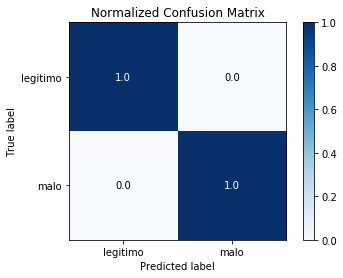

In [196]:
import scikitplot
scikitplot.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

c:\python35\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
c:\python35\lib\site-packages\sklearn\model_selection\_validation.py:1192: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes' 4 instead of 5).
  % (train_sizes_abs.shape[0], n_ticks), RuntimeWarning)


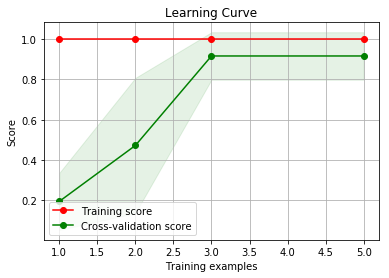

In [197]:
# graficando el aprendizaje de curva

scikitplot.estimators.plot_learning_curve(clf,X_train,y_train)

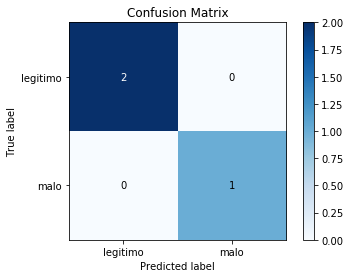

In [198]:
#confusion matriz segun scikitplot
scikitplot.metrics.plot_confusion_matrix(y_test, y_pred)

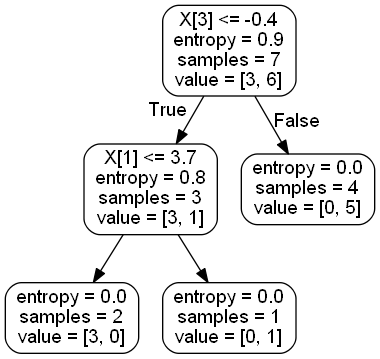

In [199]:
# graficando
import graphviz
from sklearn.datasets import load_iris
from sklearn import tree
import pydotplus
from sklearn.externals.six import StringIO  
from IPython.display import Image
dot_data = StringIO()
# print(clf.estimators_)
tree.export_graphviz(clf.estimators_[1], out_file=dot_data,rounded = True,precision=1)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())